In [9]:
import timeit
import torch
from torchvision.models.resnet import resnet50
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.autograd import Variable

from skvideo.io import VideoCapture

# import matplotlib
# matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# Visual
class VisualNetwork(torch.nn.Module):
    def __init__(self):
        super(VisualNetwork, self).__init__()
        self.base = resnet50(pretrained=True)
                
    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        f4 = self.base.layer4(x)

        fpool = F.adaptive_avg_pool2d(f4, 1)
        return fpool, f4

In [4]:
# Temporal LSTM
lstm = torch.nn.LSTM(2048, 2048)

In [6]:
# Define Visual Network
visual_sensor = VisualNetwork()
visual_sensor = visual_sensor.cuda()

# Define Temporal Network
# temporal_net = TemporalNetwork()
# temporal_net.cuda()


<IPython.core.display.Javascript object>


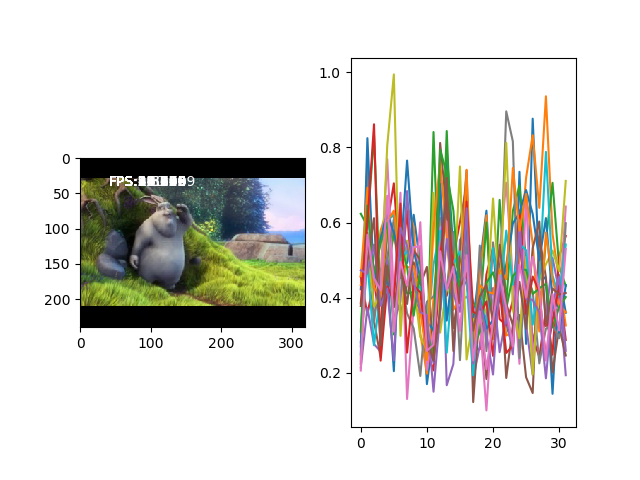

<IPython.core.display.Javascript object>


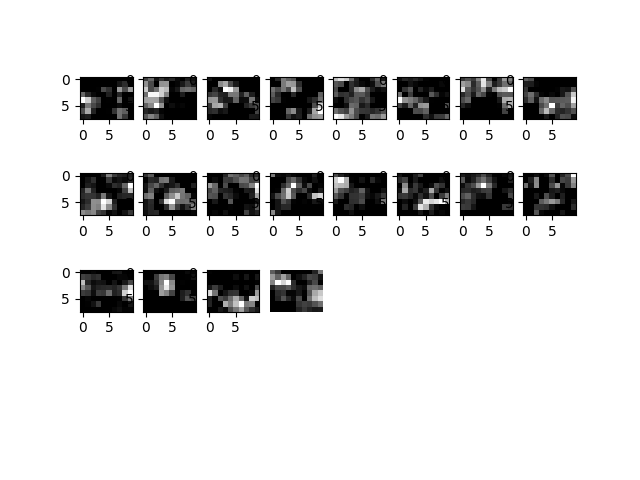

KeyboardInterrupt: 

In [45]:
def np_to_tensor(nparray):
    x = image.astype('float')
    x.transpose((2, 0, 1))    
    x = ToTensor()(x)
#     x = Variable(x.cuda(), volatile=True)
    x -= 0.5
    return x.cuda()

fname = '/home/siqi/Downloads/SampleVideo_360x240_30mb.mp4'
cap = VideoCapture(fname)
cap.open()

f1, ax1 = plt.subplots(1,2)
f2, ax2 = plt.subplots(4,8)
plt.ion()

SKIP = 5
BUFFSZ = 8
image_buffer = [0]*BUFFSZ
buffer = torch.FloatTensor(BUFFSZ, 3, 240, 320).cuda()

FPS = 0
t_buffer_start = timeit.default_timer()

bufferidx = 0
frameidx = 0
while True:    
    retval, image = cap.read()    
    if frameidx % SKIP is not 0:
        frameidx += 1
        continue
    else:
        frameidx += 1
        # Fill the buffer
        x = np_to_tensor(image)        
        image_buffer[bufferidx] = image
        buffer[bufferidx,:,:,:] = x
        bufferidx +=1
            
    if bufferidx < BUFFSZ:
        continue
         
    fpool, f4 = visual_sensor(Variable(buffer, volatile=True))    
    vcode = fpool.data[:,:32,:,:].cpu() # For inspection
    f4 = f4.data[:,:32,:,:].cpu().numpy() # For inspection
    
    for b in range(BUFFSZ):        
        frame = image_buffer[b]
        code = vcode[b,:,:,:].squeeze().cpu().numpy()
        try:
            ax1[0].imshow(frame)
        except TypeError:
            print(frame)
        
        ax1[1].plot(code)
        FPS = 1 / ((timeit.default_timer() - t_buffer_start) / frameidx)
        ax1[0].text(40, 40, 'FPS:%.3f' % FPS, color='w')        

        for f in range(32):
            ax2[f//8, f%8].imshow(f4[b, f, :, :], cmap='gray')
        

        f1.show()
        f2.show()
        f1.canvas.draw()
        f2.canvas.draw() 
           
    bufferidx = 0
    
    # Clear the buffer
    image_buffer = [0]*BUFFSZ
    buffer = torch.FloatTensor(BUFFSZ, 3, 240, 320).cuda()
    
    if not retval:
        break